In [0]:
# Reading data from google drive
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticating and creating the Drive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# The sharing URL: https://drive.google.com/open?id=13LZcIgT0m4SafyGE3nfOlIjF6Hvlfyw7

df = drive.CreateFile({'id': '13LZcIgT0m4SafyGE3nfOlIjF6Hvlfyw7'})
df.GetContentFile('roads.zip')

!unzip roads.zip

In [0]:
import tensorflow as tf
import numpy as np
import glob

bad = glob.glob('roads/bad/*.*')
good = glob.glob('roads/good/*.*')

Arr = []
Y = []

for i in bad:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (400,300))
    image=np.array(image)
    Arr.append(image)
    Y.append(0)

for i in good:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (400,300))
    image=np.array(image)
    Arr.append(image)
    Y.append(1)

In [0]:
Arr = np.array(Arr)
Y = np.array(Y)

In [0]:
Arr.shape

(592, 400, 300, 3)

In [0]:
import pandas as pd
Y = pd.get_dummies(Y).to_numpy()

In [0]:
Y.shape

(592, 2)

In [0]:
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.models import Model

Using TensorFlow backend.


In [0]:
## building the network
def resnet_layer(inputs,num_filters=16,kernel_size=3,strides=1,activation='relu',batch_normalization=True,conv_first=True):
     
    conv = Conv2D(num_filters,kernel_size=kernel_size,strides=strides,padding='same',kernel_initializer='he_normal',kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [0]:
def resnet_v1(input_shape, depth, num_classes=2):
    
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,num_filters=num_filters,strides=strides)
            y = resnet_layer(inputs=y,num_filters=num_filters,activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,num_filters=num_filters,kernel_size=1,strides=strides,activation=None,batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [0]:
model = resnet_v1(input_shape=(400,300,3), depth=32)

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400, 300, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 400, 300, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 400, 300, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 400, 300, 16) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
#cross validation
from sklearn.model_selection import train_test_split,KFold
kf=KFold(10,True,1)
for train_index,test_index in kf.split(Arr):
    print("Train Index: ", train_index)
    print("Test Index: ", test_index)
    print("\n")

Train Index:  [  1   2   3   4   5   6   7   8   9  10  11  12  14  15  16  17  18  19
  20  21  22  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  42  43  44  45  46  48  50  51  52  53  54  55  56  57  58  60
  61  62  63  64  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 108 109 110 112 113 114 115 116 117 118 119
 120 121 122 123 125 126 127 128 129 130 131 133 134 136 137 138 139 140
 141 142 143 144 145 146 148 149 150 151 152 153 154 155 156 157 158 159
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 251 252 253
 254 255 256 257 262 263 264 265 266 

In [0]:
print(train_index.shape)

(533,)


In [0]:
print(test_index.shape)

(59,)


In [0]:
X_train, X_test, y_train, y_test = Arr[train_index], Arr[test_index], Y[train_index], Y[test_index]

In [0]:
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
model.fit(X_train,y_train,epochs=10,verbose=1, validation_data=(X_test,y_test))

Train on 533 samples, validate on 59 samples
Epoch 1/10
533/533 [==============================] - 40s 74ms/step - loss: 2.8543 - accuracy: 0.6135 - val_loss: 5843.0170 - val_accuracy: 0.4915
Epoch 2/10
533/533 [==============================] - 23s 44ms/step - loss: 0.8486 - accuracy: 0.7917 - val_loss: 426.3419 - val_accuracy: 0.4746
Epoch 3/10
533/533 [==============================] - 23s 44ms/step - loss: 0.8149 - accuracy: 0.7917 - val_loss: 159.6758 - val_accuracy: 0.4746
Epoch 4/10
533/533 [==============================] - 23s 44ms/step - loss: 0.6267 - accuracy: 0.8349 - val_loss: 70.9679 - val_accuracy: 0.5932
Epoch 5/10
533/533 [==============================] - 23s 44ms/step - loss: 0.5908 - accuracy: 0.8649 - val_loss: 29.6725 - val_accuracy: 0.5593
Epoch 6/10
533/533 [==============================] - 23s 44ms/step - loss: 0.4847 - accuracy: 0.8987 - val_loss: 5.7398 - val_accuracy: 0.7119
Epoch 7/10
533/533 [==============================] - 23s 44ms/step - loss: 0.4473

In [0]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 79.66%


In [0]:
# testing a single photo
photo_test=X_test[9]

Actual Image.


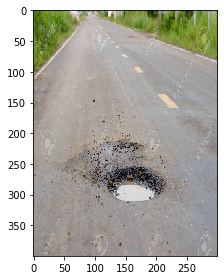

In [0]:
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
imshow(photo_test)
print("Actual Image.")

In [0]:
model.predict(X_test[9:10]) # model predicts this image as [1, 0] because probability is high at first position [66.52%,  33.47%]

array([[0.9310597 , 0.06894029]], dtype=float32)

In [0]:
y_test[9:10]   # this is actual true value [1, 0]. 

array([[1, 0]], dtype=uint8)

**So, the model predicted nearly correct :)** 